In [132]:
import pandas as pd

In [133]:
pd.set_option('display.max_columns', None)

In [134]:
dfs = pd.read_csv('Data/us/shot_logs.csv')

In [135]:
# remove match_id 22854
# remove result == 'OwnGoal'

dfs = dfs[dfs['match_id'] != 22854]
dfs = dfs[dfs['result'] != 'OwnGoal']

In [136]:
df = dfs[['id','player_id','X','Y','lastAction','shotType_Head','shotType_LeftFoot','shotType_OtherBodyPart',
         'shotType_RightFoot','situation_DirectFreekick','situation_FromCorner','situation_OpenPlay','situation_Penalty',
         'situation_SetPiece','result','xG']]

In [137]:
# rename columns
cols = {
    'X': 'shot_location_x',
    'Y': 'shot_location_y',
    'shotType_Head' : 'header',
    'result': 'goal'
}

df = df.rename(columns=cols)
df.head()

,id,player_id,shot_location_x,shot_location_y,lastAction,header,shotType_LeftFoot,shotType_OtherBodyPart,shotType_RightFoot,situation_DirectFreekick,situation_FromCorner,situation_OpenPlay,situation_Penalty,situation_SetPiece,goal,xG
0,24501,356,104.160004,36.879999,Aerial,1,0,0,0,0,0,1,0,0,SavedShot,0.026551
1,25008,356,105.600000,30.879999,Pass,0,0,0,1,0,0,1,0,0,BlockedShot,0.072646
2,25026,356,113.639996,49.839999,Cross,1,0,0,0,0,0,1,0,0,MissedShots,0.033752
3,25028,356,116.400000,30.720001,NaN,0,0,0,1,0,1,0,0,0,Goal,0.073383
4,25041,356,112.560004,41.279999,Cross,1,0,0,0,0,1,0,0,0,MissedShots,0.127458


In [138]:
# convert goal to boolean
df['goal'] = df['goal'].apply(lambda x: 1 if x == 'Goal' else 0)

In [139]:
import numpy as np
import pandas as pd

# Function to calculate the distance to the goal
def distance_to_goal(df):
    """
    Calculates the distance from the shot location to the goal.

    :param df: pandas DataFrame with 'shot_location_x' and 'shot_location_y' columns.
    :return: Updated DataFrame with an additional 'distance_to_goal' column, rounded to 4 decimal places.
    """
    goal_x, goal_y = 120, 40
    df['distance_to_goal'] = np.sqrt((df['shot_location_x'] - goal_x) ** 2 + (df['shot_location_y'] - goal_y) ** 2).round(4)
    return df

# Function to calculate the angle to the goal
def calculate_shot_angle(shot_x, shot_y):
    """
    Calculates the angle between two vectors pointing to the left and right goalposts from a shot location.

    :param shot_x: Float representing the x-coordinate of the shot location.
    :param shot_y: Float representing the y-coordinate of the shot location.
    :return: Angle in degrees between the shot location and the two goalposts.
    """
    goal_x1, goal_y1 = 120, 36  # Left post
    goal_x2, goal_y2 = 120, 44  # Right post

    # Vectors to the posts
    u_x, u_y = goal_x1 - shot_x, goal_y1 - shot_y
    v_x, v_y = goal_x2 - shot_x, goal_y2 - shot_y

    # Dot product and magnitudes
    dot_product = u_x * v_x + u_y * v_y
    magnitude_u = np.sqrt(u_x**2 + u_y**2)
    magnitude_v = np.sqrt(v_x**2 + v_y**2)

    # Avoid division by zero
    if magnitude_u == 0 or magnitude_v == 0:
        return 0.0

    # Calculate angle in radians
    angle_radians = np.arccos(dot_product / (magnitude_u * magnitude_v))

    # Convert to degrees
    return np.degrees(angle_radians)

# Function to calculate and add the shot angle column
def get_shot_angle(df):
    """
    Calculates the shot angle relative to the goalposts and adds it to the DataFrame.

    :param df: pandas DataFrame with 'shot_location_x' and 'shot_location_y' columns.
    :return: Updated DataFrame with an additional 'shot_angle' column containing the angle in degrees.
    """
    df['shot_angle'] = df.apply(lambda row: calculate_shot_angle(row['shot_location_x'], row['shot_location_y']), axis=1)
    return df


In [140]:
df = distance_to_goal(df)
df = get_shot_angle(df)

In [141]:
# preferred foot shot
# players take penalties and free kicks with their preferred foot
# so we take the foot that was used for the penalty or free kick
# and for that player we assume its his preferred foot
# for the rest of the shooters, we calculate the foot that was used the most
c = ['player_id','shotType_LeftFoot','shotType_RightFoot','situation_Penalty','situation_DirectFreekick']
pf_df = df[(df['situation_Penalty']==1) | (df['situation_DirectFreekick']==1)][c]

In [142]:
# where both are not 0
len(pf_df[(pf_df['shotType_LeftFoot']!=0) & (pf_df['shotType_RightFoot']!=0)])

0

In [143]:
# sum of shotType_LeftFoot and shotType_RightFoot by player_id
pf_df.groupby('player_id').agg({'shotType_LeftFoot':'sum', 'shotType_RightFoot':'sum'}).reset_index()

,player_id,shotType_LeftFoot,shotType_RightFoot
0,5,3,0
1,8,0,65
2,9,0,26
3,11,0,35
4,12,52,0
...,...,...,...
2973,12986,0,2
2974,13005,1,0
2975,13037,0,1
2976,13038,1,0


In [144]:
# compare the sum of shotType_LeftFoot and shotType_RightFoot and take the name of the column with the highest sum
pf_df['preferred_foot_shot'] = np.where(pf_df['shotType_LeftFoot']>pf_df['shotType_RightFoot'], 'Left', 'Right')
pf_df

,player_id,shotType_LeftFoot,shotType_RightFoot,situation_Penalty,situation_DirectFreekick,preferred_foot_shot
5,356,0,1,0,1,Right
16,356,0,1,0,1,Right
29,356,0,1,0,1,Right
35,356,0,1,0,1,Right
49,356,0,1,1,0,Right
...,...,...,...,...,...,...
3704164,11696,1,0,0,1,Left
3704188,11881,0,1,0,1,Right
3704195,11934,0,1,1,0,Right
3704443,12676,1,0,0,1,Left


In [145]:
df.to_csv('df.csv', index=False)
pf_df.to_csv('pf_df.csv', index=False)

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-ready-data').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 10:30:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/28 10:30:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df = spark.read.csv('df.csv', header=True, inferSchema=True)
pf_df = spark.read.csv('pf_df.csv', header=True, inferSchema=True)

In [3]:
df.count(), pf_df.count()

(3693939, 210111)

In [4]:
# Collect pf_df as a dictionary
pf_dict = {row['player_id']: row['preferred_foot_shot'] for row in pf_df.collect()}

# Define a UDF to map player_id to preferred_foot
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import when, col

def map_preferred_foot(player_id):
    return pf_dict.get(player_id, 'Other')  # Default to 'Other' if not found

map_preferred_foot_udf = udf(map_preferred_foot, StringType())

# Apply the UDF to create the preferred_foot_shot column
df = df.withColumn('preferred_foot', map_preferred_foot_udf(df['player_id']))

# Count the occurrences of each value
value_counts = df.groupBy('preferred_foot').count()

# Show the counts
value_counts.show()

+--------------+-------+
|preferred_foot|  count|
+--------------+-------+
|          Left| 774322|
|         Other| 779549|
|         Right|2140068|
+--------------+-------+



In [5]:
df.show()

+-----+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+
|   id|player_id|   shot_location_x|   shot_location_y| lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|situation_DirectFreekick|situation_FromCorner|situation_OpenPlay|situation_Penalty|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|
+-----+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+
|24501|      356|104.16000366210938| 36.87999877929687|     Aeri

In [6]:
df_calc = df.filter(df.preferred_foot=='Other').select('player_id','shotType_LeftFoot','shotType_RightFoot')

In [7]:
df_calc.count()

779549

In [8]:
# if both are 0, we remove the row
df_calc = df_calc.filter((df_calc.shotType_LeftFoot!=0) | (df_calc.shotType_RightFoot!=0))
df_calc.count()

562437

In [9]:
# sum of shotType_LeftFoot and shotType_RightFoot by player_id
df_calc = df_calc.groupby('player_id').agg({'shotType_LeftFoot':'sum', 'shotType_RightFoot':'sum'})
# rename columns
df_calc = df_calc.withColumnRenamed('sum(shotType_LeftFoot)', 'shotType_LeftFoot').withColumnRenamed('sum(shotType_RightFoot)', 'shotType_RightFoot')
df_calc.show()

+---------+-----------------+------------------+
|player_id|shotType_LeftFoot|shotType_RightFoot|
+---------+-----------------+------------------+
|     2659|               49|               140|
|     5300|               16|                 0|
|      858|               10|                 5|
|      243|               14|                44|
|     1084|               32|               200|
|       31|                4|                 2|
|     4239|                7|                 0|
|      251|               84|                30|
|     5308|                3|                 1|
|     5223|                0|                 6|
|     6597|                0|                15|
|     4294|                3|                 3|
|     2656|                0|                 1|
|       53|                0|                 2|
|     7109|              276|               456|
|     6557|               15|                35|
|       78|               24|                30|
|      322|         

In [10]:
# compare the sum of shotType_LeftFoot and shotType_RightFoot and take the name of the column with more than 60% of the sum
df_calc = df_calc.withColumn('preferred_foot', when(col('shotType_LeftFoot')>col('shotType_RightFoot'), 'Left') \
                             .when(col('shotType_RightFoot')>col('shotType_LeftFoot'), 'Right') \
                             .otherwise('TwoFooted'))
df_calc.show()

+---------+-----------------+------------------+--------------+
|player_id|shotType_LeftFoot|shotType_RightFoot|preferred_foot|
+---------+-----------------+------------------+--------------+
|     2659|               49|               140|         Right|
|     5300|               16|                 0|          Left|
|      858|               10|                 5|          Left|
|      243|               14|                44|         Right|
|     1084|               32|               200|         Right|
|       31|                4|                 2|          Left|
|     4239|                7|                 0|          Left|
|      251|               84|                30|          Left|
|     5308|                3|                 1|          Left|
|     5223|                0|                 6|         Right|
|     6597|                0|                15|         Right|
|     4294|                3|                 3|     TwoFooted|
|     2656|                0|           

In [11]:
df_calc.groupBy('preferred_foot').count().show()

+--------------+-----+
|preferred_foot|count|
+--------------+-----+
|          Left| 1348|
|     TwoFooted|  244|
|         Right| 3526|
+--------------+-----+



In [12]:
df_o = df.filter(df.preferred_foot=='Other')
df_f = df.filter(df.preferred_foot!='Other')

In [13]:
df_o.count(), df_f.count()

(779549, 2914390)

In [14]:
# Collect df_calc as a dictionary (player_id -> preferred_foot)
calc_dict = {row['player_id']: row['preferred_foot'] for row in df_calc.collect()}

# Define a UDF to map player_id to preferred_foot_shot using df_calc
def map_preferred_foot_from_calc(player_id):
    return calc_dict.get(player_id, 'Other')  # Default to 'Other' if not found

map_preferred_foot_from_calc_udf = udf(map_preferred_foot_from_calc, StringType())

# Apply the UDF to create the preferred_foot_shot column in df
df_o = df_o.withColumn('preferred_foot', map_preferred_foot_from_calc_udf(df['player_id']))

# Count the occurrences of each value in the new preferred_foot_shot column
value_counts = df_o.groupBy('preferred_foot').count()

# Show the counts
value_counts.show()

+--------------+------+
|preferred_foot| count|
+--------------+------+
|          Left|157631|
|         Other|   931|
|     TwoFooted|  5074|
|         Right|615913|
+--------------+------+



In [15]:
# replace Other with TwoFooted in df_o
df_o = df_o.withColumn('preferred_foot', when(col('preferred_foot')=='Other', 'TwoFooted').otherwise(col('preferred_foot')))
df_o.groupBy('preferred_foot').count().show()

+--------------+------+
|preferred_foot| count|
+--------------+------+
|          Left|157631|
|     TwoFooted|  6005|
|         Right|615913|
+--------------+------+



In [16]:
# Combine the two DataFrames
df = df_f.union(df_o)

In [17]:
# create preferred_foot_shot column with 1 when shotType_LeftFoot is 1 and preferred_foot is Left or
# when shotType_RightFoot is 1 and preferred_foot is Right or
# when any of the shotType_LeftFoot or shotType_RightFoot is 1 and preferred_foot is TwoFooted
df = df.withColumn('preferred_foot_shot', when((col('shotType_LeftFoot')==1) & (col('preferred_foot')=='Left'), 1) \
                   .when((col('shotType_RightFoot')==1) & (col('preferred_foot')=='Right'), 1) \
                   .when(((col('shotType_LeftFoot')==1) | (col('shotType_RightFoot')==1)) & (col('preferred_foot')=='TwoFooted'), 1) \
                   .otherwise(0))

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('ml-ready-data').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 08:41:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('understat/understat.csv', header=True, inferSchema=True)

In [4]:
df.select('shot_location_x','shot_location_y','header','situation_DirectFreekick','situation_FromCorner','situation_OpenPlay',
          'situation_Penalty','situation_SetPiece','distance_to_goal','shot_angle','preferred_foot_shot').show()

+------+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+-------------------+
|    id|player_id|   shot_location_x|   shot_location_y| lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|situation_DirectFreekick|situation_FromCorner|situation_OpenPlay|situation_Penalty|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|
+------+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+-------------------+
|

In [43]:
events = spark.read.csv('Data/events_0_359.csv', header=True, inferSchema=True,sep=';')

In [18]:
df.filter(df.situation_OpenPlay==1).count(), df.filter(df.situation_Penalty==1).count(), df.filter(df.situation_DirectFreekick==1).count()

(2722545, 50776, 159335)

In [19]:
# rename columns
cols = {
    'situation_DirectFreekick': 'fk_type',
    'situation_OpenPlay': 'regular_play',
    'situation_Penalty': 'pk_type',
    'situation_Corner': 'from_corner',
}
dfs = df.withColumnsRenamed(cols)
dfs.show()

+-----+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+-------+--------------------+------------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+
|   id|player_id|   shot_location_x|   shot_location_y| lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|situation_FromCorner|regular_play|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|
+-----+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+-------+--------------------+------------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+
|24501|      356|104.16000366210938| 36.87999877929687|     Aerial|     1|                0|           

In [20]:
shots = spark.read.csv('Data/Datas/shots.csv', header=True, inferSchema=True)

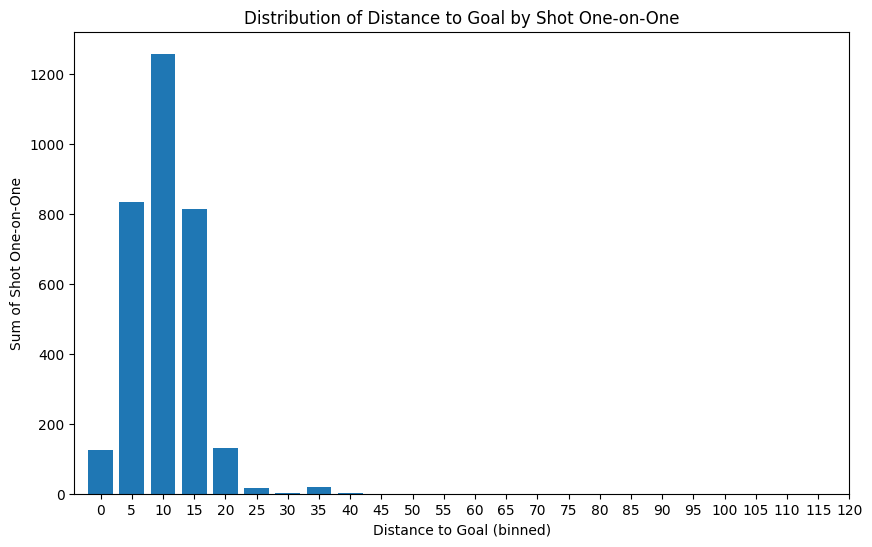

In [33]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

s = shots.filter(shots.shot_one_on_one==1)

# Define bins for distance_to_goal (e.g., 10m intervals)
bins = list(range(0, 121, 5))

# Add a new column for binned distances
df_binned = s.withColumn("distance_bin", (F.col("distance_to_goal") / 5).cast("int") * 5)

# Group by bins and calculate sum of shot_one_on_one
result = df_binned.groupBy("distance_bin").agg(F.sum("shot_one_on_one").alias("total_shots"))

# Collect the data for plotting
data = result.orderBy("distance_bin").collect()

# Extract x and y for plotting
x = [row["distance_bin"] for row in data]
y = [row["total_shots"] for row in data]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(x, y, width=4, align='center')  # Adjust bar width for better spacing
plt.xticks(bins)
plt.xlabel("Distance to Goal (binned)")
plt.ylabel("Sum of Shot One-on-One")
plt.title("Distribution of Distance to Goal by Shot One-on-One")
plt.show()


In [47]:
ML_READY_DATA_DUMMIES = [
    'id','player_id',
    'shot_location_x','shot_location_y','distance_to_goal','shot_angle', # Spatial data
    'preferred_foot_shot', # Boolean
    'from_rp','from_fk','from_corner', # Play pattern
    'header','corner_type','fk_type','pk_type', # Shot type
    'acrobatic_finish', # Shot technique
    'under_pressure','shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble', # Boolean
    'players_inside_area', # Spatial data
    'shot_statsbomb_xg','shot_outcome','goal']

In [54]:
FEATURES = ['other_pp','from_fk','from_ti','from_corner','from_counter','from_gk','from_keeper','from_ko',
            'header','corner_type','fk_type','pk_type',
            'half_volley_technique','volley_technique','lob_technique','overhead_technique','backheel_technique',
            'diving_h_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot', 'under_pressure',
            'shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble','players_inside_area']

In [56]:
df_sh = shots.select(FEATURES).toPandas()

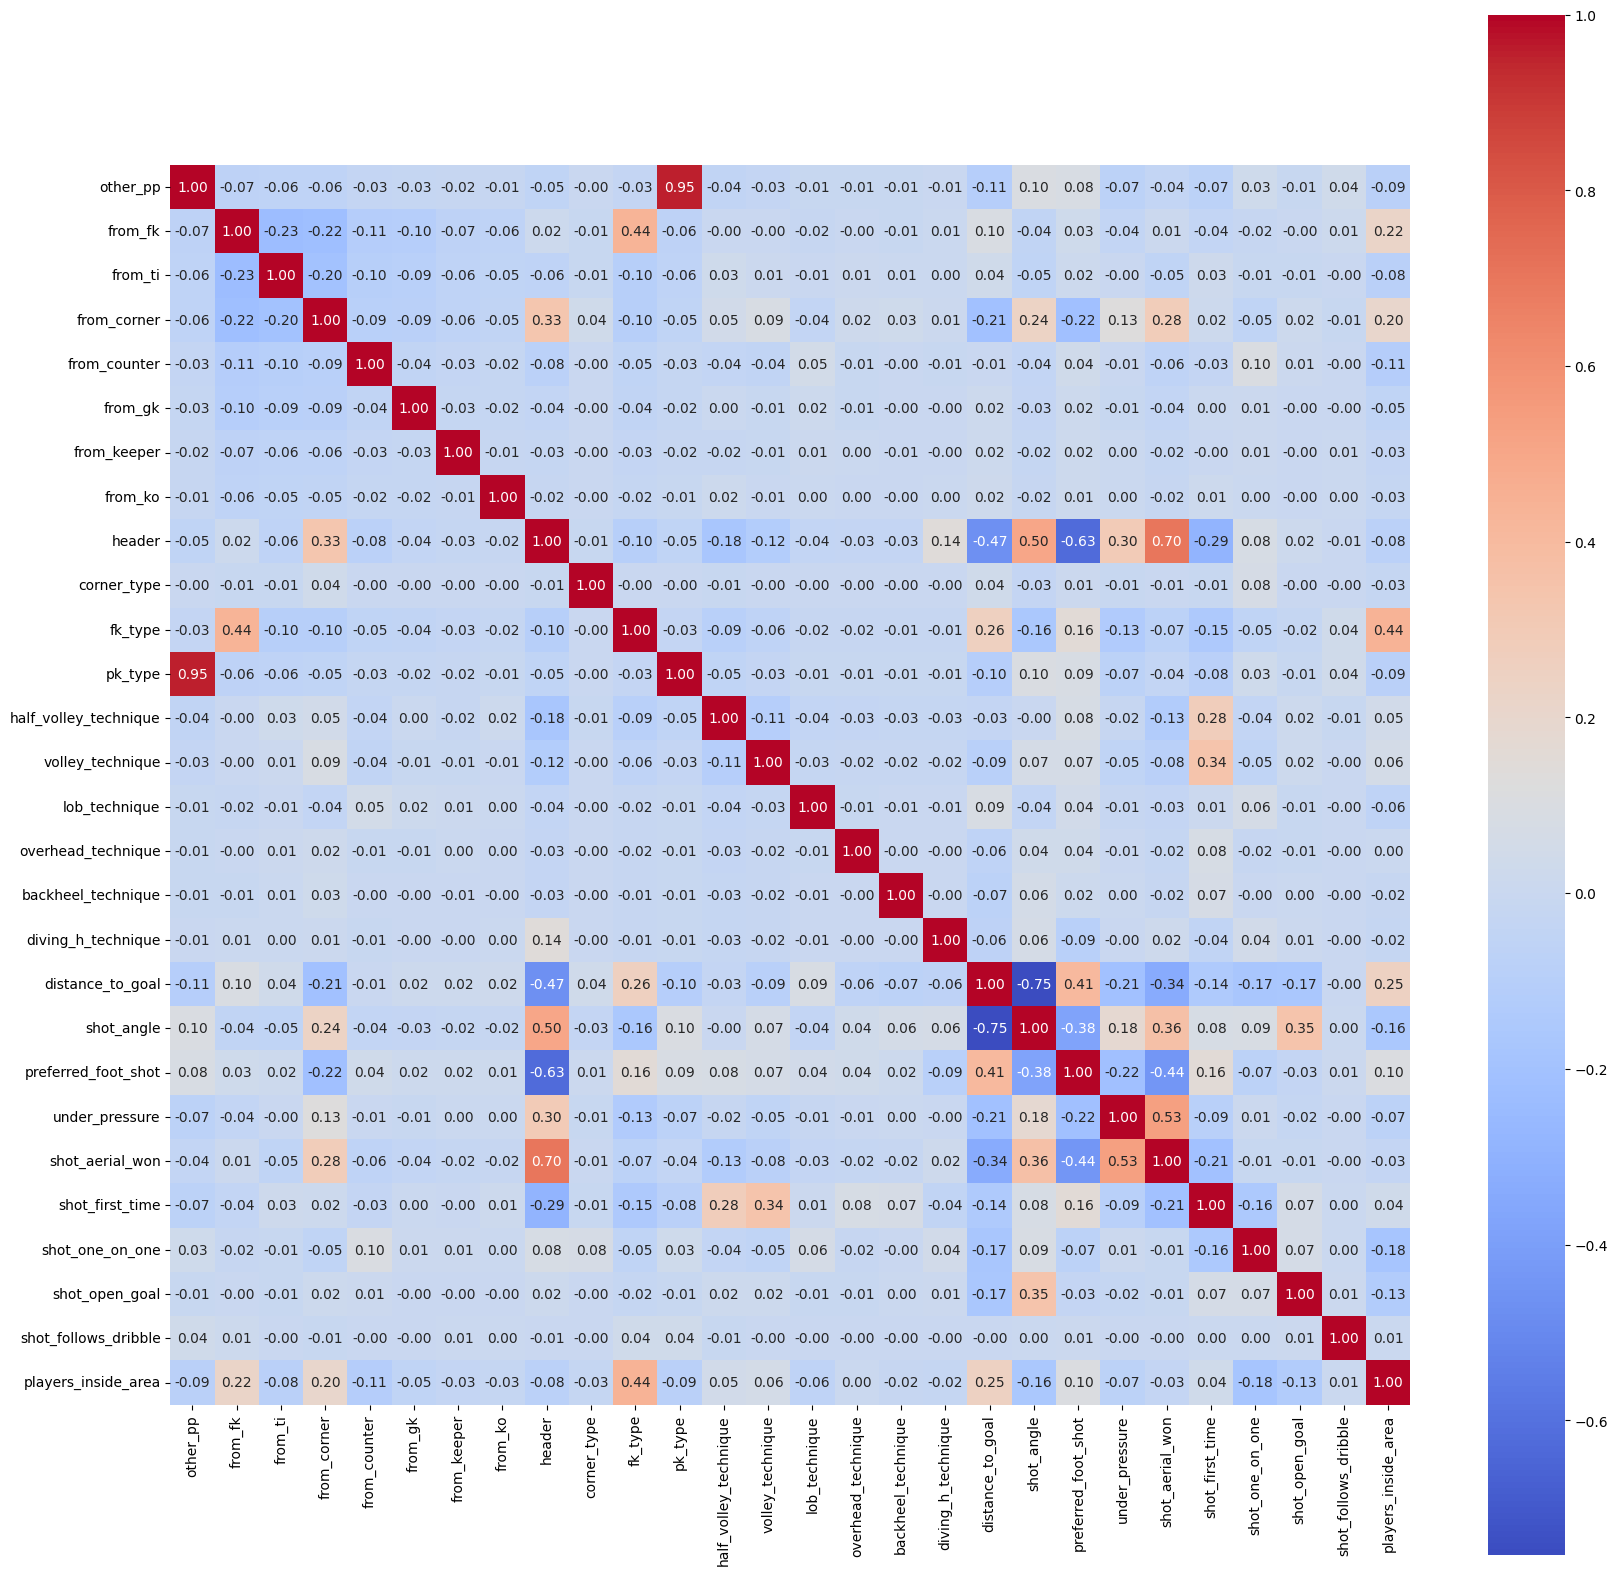

In [57]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(df_sh.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
    
plt.show()

In [1]:
# lastAction = Cross + situation_SetPiece -> from_fk
# lastAction = TakeOn/GoodSkill -> shot_follows_dribble
# lastAction = BallTouch -> shot_first_time
# lastAction = Aerial/Chipped + shotType_LeftFoot / shotType_RightFoot -> volley_technique / half_volley_technique
# lastAction = throughball -> shot_one_on_one
# lastAction = Rebound -> shot_first_time / shot_one_on_one / shot_open_goal

In [21]:
dfs.filter(dfs.xG==0.0).count()

0

In [22]:
shots = dfs

In [ ]:
# rename columns
cols = {
    'situation_DirectFreekick': 'fk_type',
    'situation_OpenPlay': 'regular_play',
    'situation_Penalty': 'pk_type',
    'situation_Corner': 'from_corner',
}
shots = shots.withColumnsRenamed(cols)
shots.show()

In [ ]:
shots = shots.withColumn(
    "from_fk",
    when((col("lastAction") == "Cross") & (col("situation_SetPiece") == 1), 1).otherwise(0))
shots = shots.withColumn(
    "shot_follows_dribble",
    when((col("lastAction") == "TakeOn") | (col("lastAction") == "GoodSkill"), 1).otherwise(0))
shots = shots.withColumn('shot_first_time',
                 when((col('lastAction') == 'BallTouch') | (col('lastAction') == 'Rebound'), 1).otherwise(0))
shots = shots.withColumn('acrobatic_shot',
                when(((col('lastAction') == 'Aerial') | (col('lastAction') == 'Chipped')) &
                     ((col('shotType_LeftFoot') == 1) | (col('shotType_RightFoot') == 1)), 1).otherwise(0))
shots = shots.withColumn('shot_one_on_one', when(col('lastAction') == 'Throughball', 1).otherwise(0))

In [23]:
# Save the DataFrame as a CSV
dfs.write.option("header", "true").csv("understat/understat.csv")